<a href="https://colab.research.google.com/github/AlbinBahtiri/Data-Science-Projects/blob/main/DataAnalyst_task_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

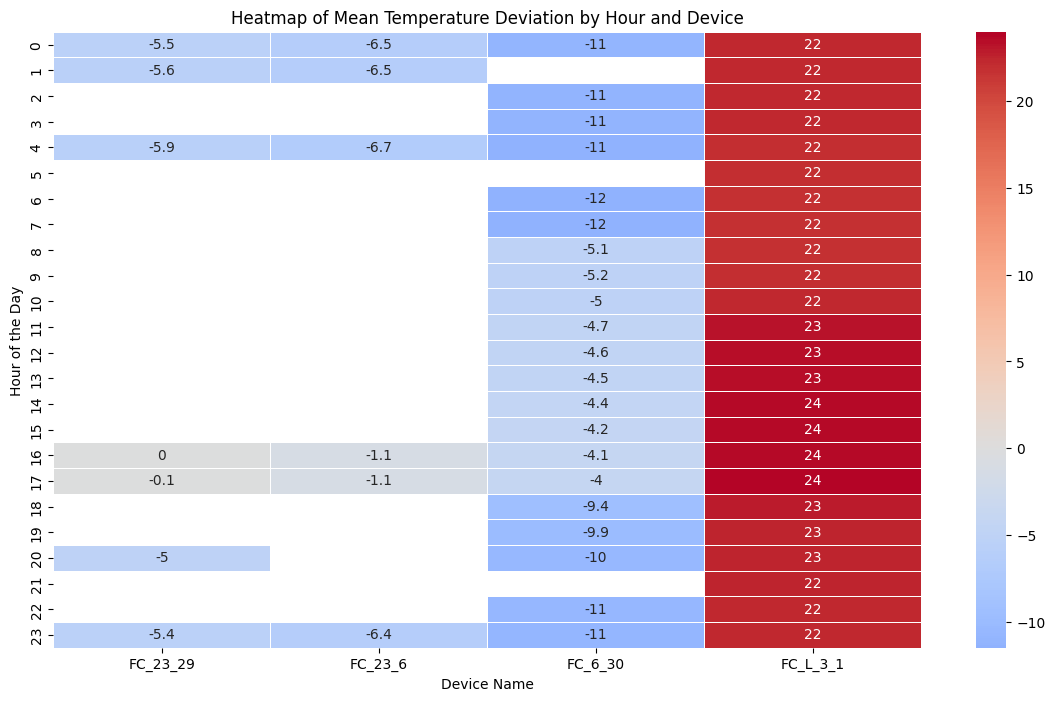


Second Graph


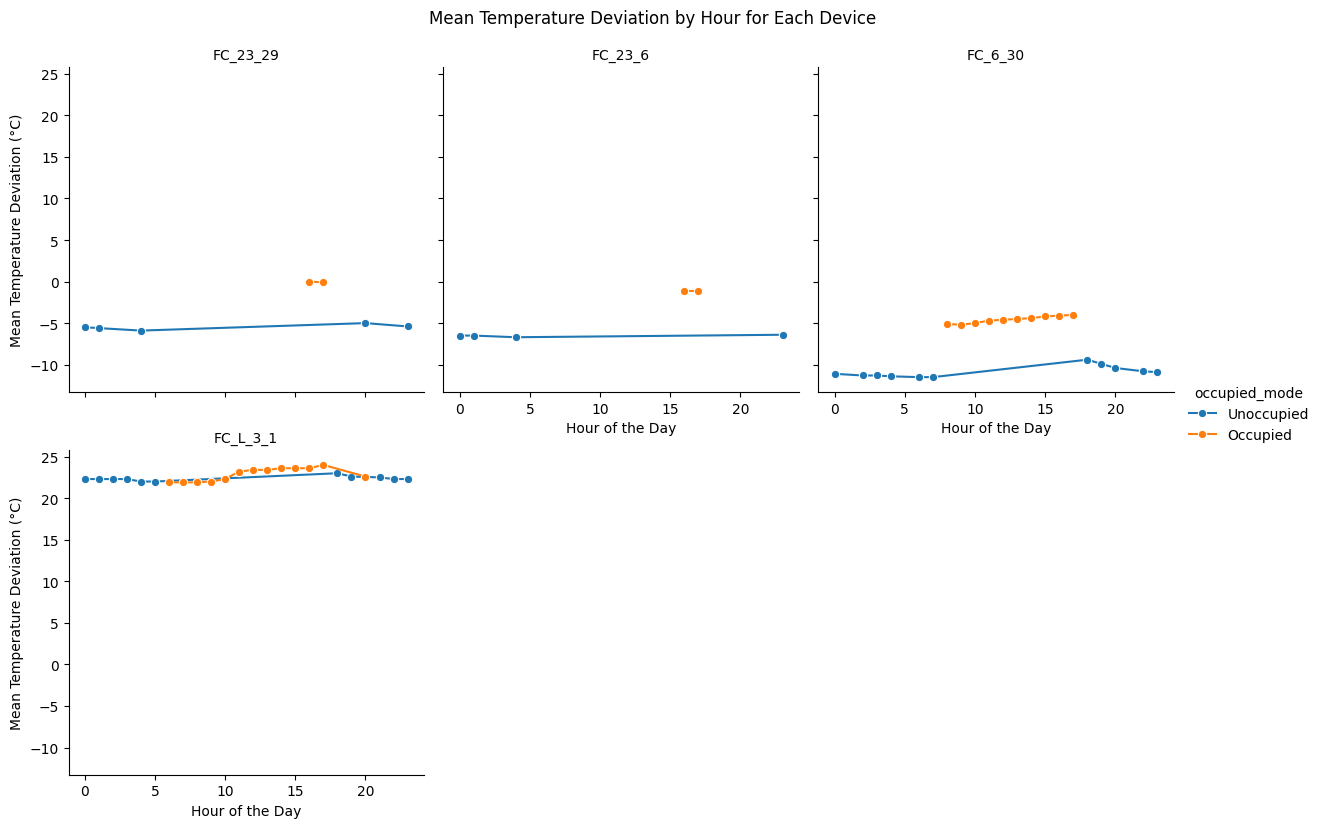

In [60]:
## Problem 1: Using the timeseries.parquet dataset, the aim is to analyze how well a device maintained the desired temperature in different occupied modes on an hourly basis throughout the day.


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = '/content/timeseries.parquet'
df = pd.read_parquet(file_path)

# Ensure datetime column is parsed correctly
df['date_time_local'] = pd.to_datetime(df['date_time_local'])

# Filter to include only relevant fields (temperature sensor, setpoint, and occupancy modes)
df_filtered = df[df['field'].isin(['zone_air_temperature_sensor', 'effective_cooling_zone_air_temperature_setpoint', 'occupied_mode'])]

# Pivot the table to have each 'field' as a column
df_pivot = df_filtered.pivot_table(index=['device_id', 'device_name', 'date_time_local'],
                                   columns='field', values='value', aggfunc='first').reset_index()

# Convert temperature-related columns to numeric values
df_pivot['zone_air_temperature_sensor'] = pd.to_numeric(df_pivot['zone_air_temperature_sensor'], errors='coerce')
df_pivot['effective_cooling_zone_air_temperature_setpoint'] = pd.to_numeric(df_pivot['effective_cooling_zone_air_temperature_setpoint'], errors='coerce')

# Handle missing values
df_pivot['occupied_mode'] = df_pivot['occupied_mode'].ffill()

# Calculate temperature deviation from the setpoint
df_pivot['temperature_deviation'] = df_pivot['zone_air_temperature_sensor'] - df_pivot['effective_cooling_zone_air_temperature_setpoint']

# Group by device, occupancy mode, and hour to analyze temperature maintenance
df_pivot['hour'] = df_pivot['date_time_local'].dt.hour

# Group by hour and occupied mode to analyze the deviation per hour
analysis = df_pivot.groupby(['device_name', 'hour', 'occupied_mode'])['temperature_deviation'].agg(['mean', 'std', 'min', 'max']).reset_index()

plt.figure(figsize=(14, 8))
heatmap_data = analysis.pivot_table(index='hour', columns='device_name', values='mean')
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', center=0, linewidths=.5)
plt.title('Heatmap of Mean Temperature Deviation by Hour and Device')
plt.xlabel('Device Name')
plt.ylabel('Hour of the Day')
plt.show()

#optionally
#second graph

print("\nSecond Graph")


g = sns.FacetGrid(analysis, col="device_name", hue="occupied_mode", col_wrap=3, height=4)
g = g.map(sns.lineplot, "hour", "mean", marker="o").add_legend()
g.set_titles("{col_name}")
g.set_axis_labels("Hour of the Day", "Mean Temperature Deviation (°C)")
g.fig.suptitle('Mean Temperature Deviation by Hour for Each Device', y=1.03)
plt.show()



  device_name         transition_time time_to_reach_setpoint
0    FC_23_29 2023-03-15 07:00:31.085 0 days 09:23:26.001000
1    FC_L_3_1 2023-03-15 06:23:02.196 0 days 01:00:01.285000
2    FC_L_3_1 2023-03-15 05:59:59.958 0 days 00:23:02.238000


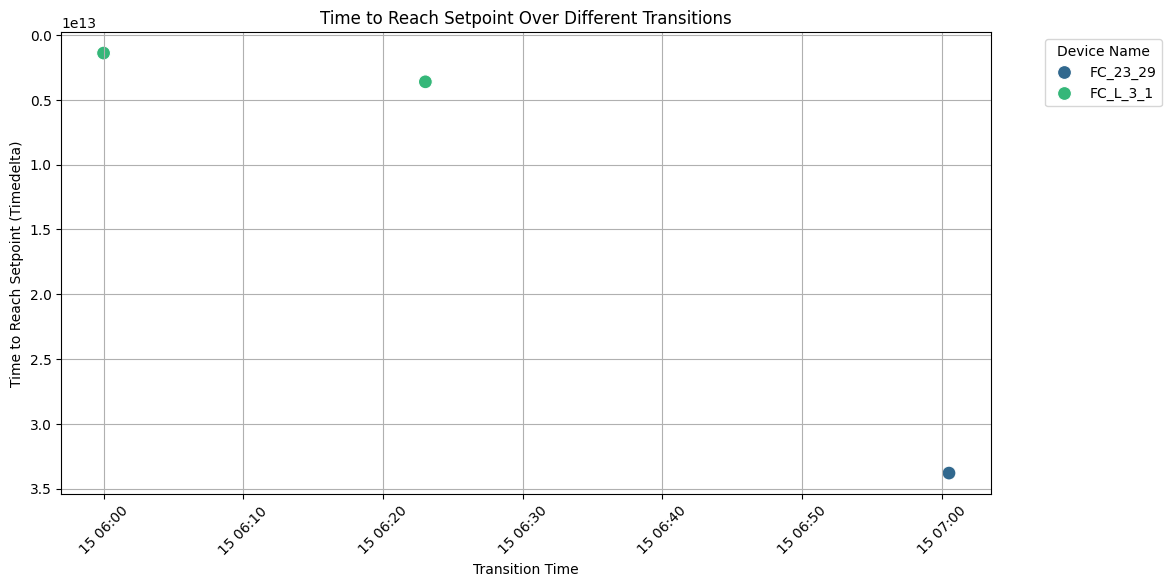

In [67]:
#Problem 2 : By analyzing the timeseries.parquet dataset, determine the time taken by a device to reach the setpoint temperature after the device turned on (occupied_mode changed from Unoccupied to Occupied).

# Load the dataset
file_path = '/content/timeseries.parquet'
df = pd.read_parquet(file_path)

# Ensure the datetime column is parsed correctly
df['date_time_local'] = pd.to_datetime(df['date_time_local'])

# Filter for relevant fields
df_filtered = df[df['field'].isin(['zone_air_temperature_sensor', 'effective_cooling_zone_air_temperature_setpoint', 'occupied_mode'])]

# Pivot the table to have each 'field' as a column
df_pivot = df_filtered.pivot_table(index=['device_id', 'device_name', 'date_time_local'],
                                   columns='field', values='value', aggfunc='first').reset_index()

# Convert the temperature-related columns to numeric values
df_pivot['zone_air_temperature_sensor'] = pd.to_numeric(df_pivot['zone_air_temperature_sensor'], errors='coerce')
df_pivot['effective_cooling_zone_air_temperature_setpoint'] = pd.to_numeric(df_pivot['effective_cooling_zone_air_temperature_setpoint'], errors='coerce')

# Forward fill the occupancy mode to ensure continuity
df_pivot['occupied_mode'] = df_pivot['occupied_mode'].ffill()

# Identify transitions from Unoccupied to Occupied
df_pivot['mode_change'] = df_pivot['occupied_mode'].shift(1) + ' to ' + df_pivot['occupied_mode']
transitions = df_pivot[df_pivot['mode_change'] == 'Unoccupied to Occupied']

# Calculate the time taken to reach the setpoint after each transition
time_to_setpoint = []

for i, transition in transitions.iterrows():
    # Filter data after the transition
    device_data = df_pivot[(df_pivot['device_id'] == transition['device_id']) & (df_pivot['date_time_local'] > transition['date_time_local'])]

    # Find the first instance where the temperature reaches the setpoint
    time_reach_setpoint = device_data[device_data['zone_air_temperature_sensor'] >= device_data['effective_cooling_zone_air_temperature_setpoint']]['date_time_local'].min()

    if pd.notna(time_reach_setpoint):
        # Calculate the time difference
        time_diff = time_reach_setpoint - transition['date_time_local']
        time_to_setpoint.append({
            'device_name': transition['device_name'],
            'transition_time': transition['date_time_local'],
            'time_to_reach_setpoint': time_diff
        })

# Convert the results to a DataFrame
result_df = pd.DataFrame(time_to_setpoint)

print(result_df)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=result_df, x='transition_time', y='time_to_reach_setpoint', hue='device_name', palette='viridis', s=100)
plt.title('Time to Reach Setpoint Over Different Transitions')
plt.xlabel('Transition Time')
plt.ylabel('Time to Reach Setpoint (Timedelta)')
plt.xticks(rotation=45)
plt.legend(title='Device Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()





Solving Problem 3: Unified Occupancy Metric


<ipython-input-63-3bba9871e237>:11: FutureWarning: Parsed string "Sun Mar 05 01:00:00 CET 2023" included an un-recognized timezone "CET". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  occupancy_csv_df['date_time'] = pd.to_datetime(occupancy_csv_df['date_time'], errors='coerce')


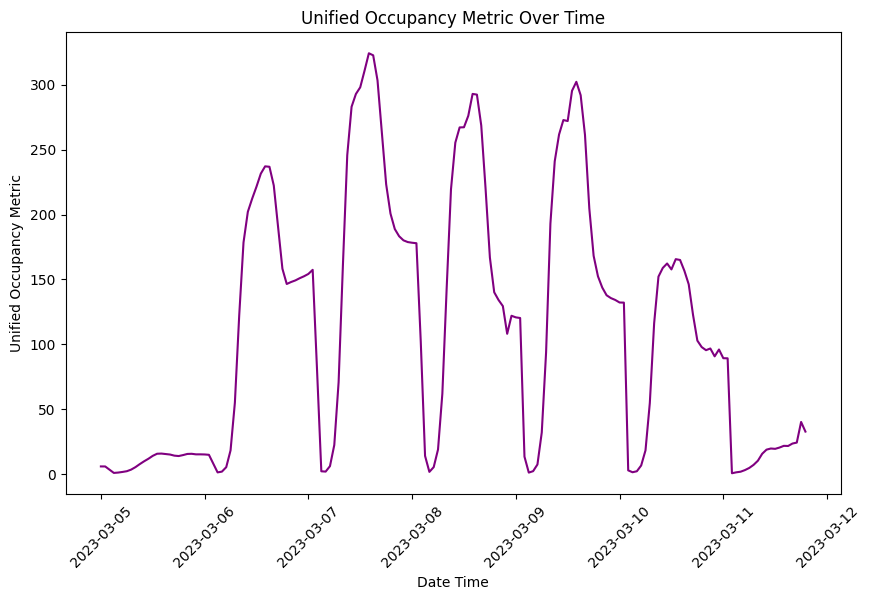

\Solving Problem 4: Dashboard for Occupancy


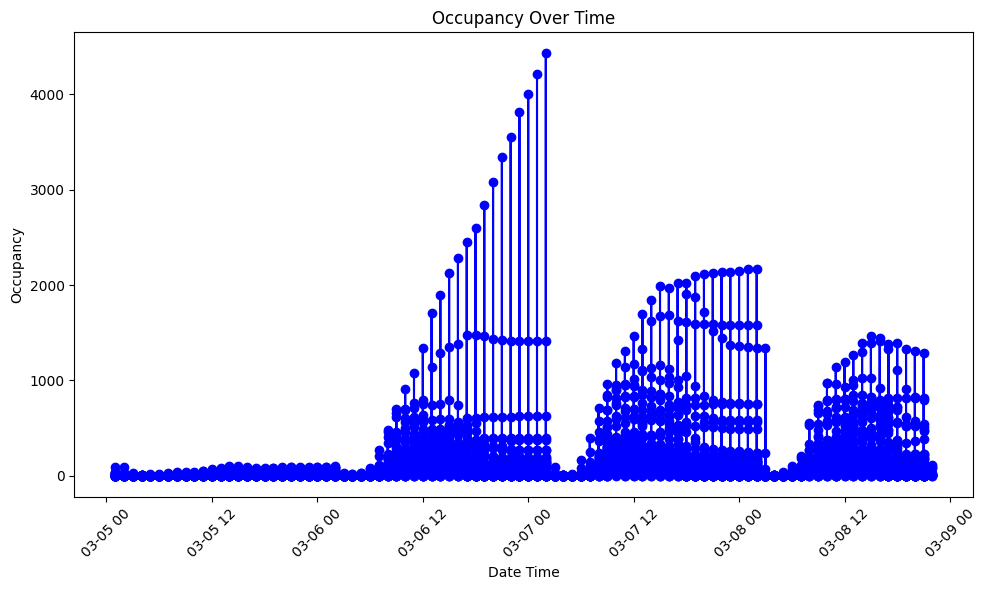

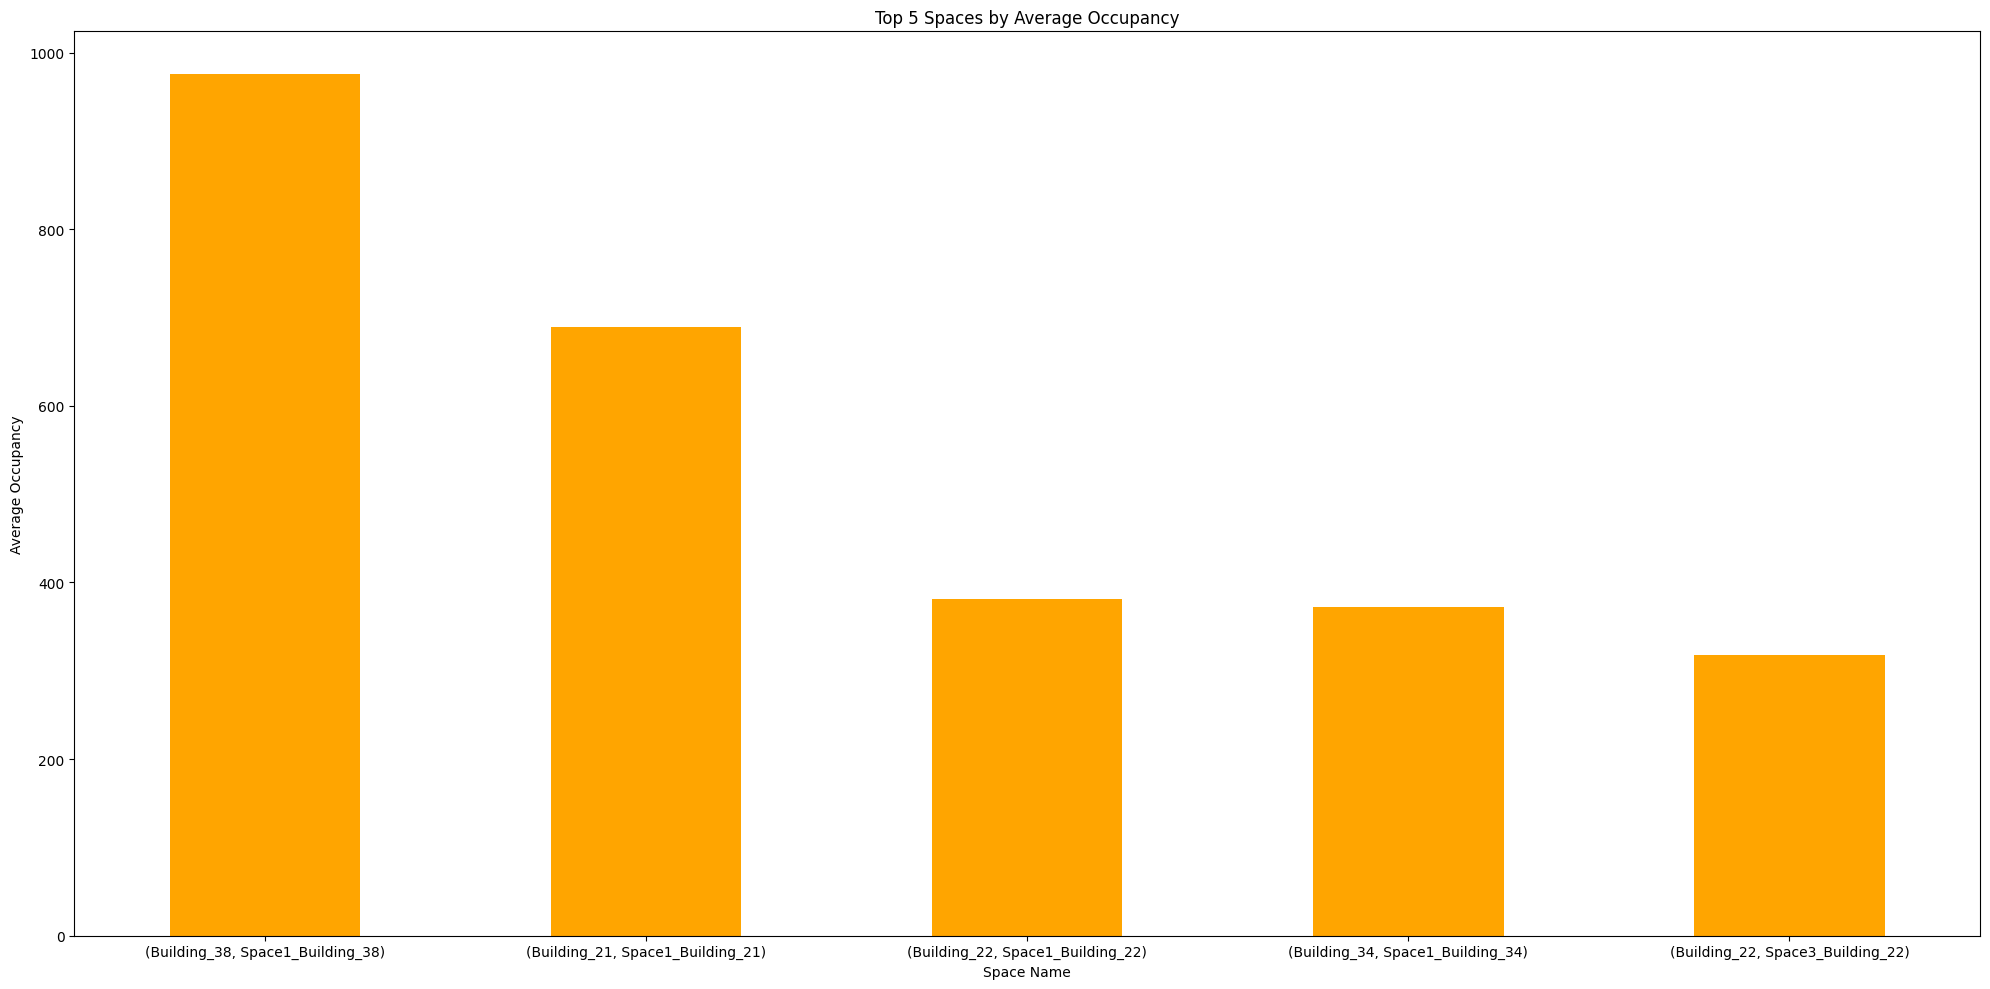

In [63]:

# function to identify and clean non-numeric values
def identify_and_clean_non_numeric(df, column):
    # Convert to numeric, setting errors='coerce'
    df[column] = pd.to_numeric(df[column], errors='coerce')
    # Drop rows where conversion failed
    return df.dropna(subset=[column])

# Problem 3: Unified Occupancy Metric
def unified_occupancy_metric(occupancy_csv_df, occupancy_parquet_df):
    # Convert 'date_time' to datetime
    occupancy_csv_df['date_time'] = pd.to_datetime(occupancy_csv_df['date_time'], errors='coerce')
    occupancy_parquet_df['date_time'] = pd.to_datetime(occupancy_parquet_df['date_time'], errors='coerce')

    # Clean 'occupancy' column
    occupancy_csv_df = identify_and_clean_non_numeric(occupancy_csv_df, 'occupancy')
    occupancy_parquet_df = identify_and_clean_non_numeric(occupancy_parquet_df, 'occupancy')

    # Combine CSV and Parquet data
    unified_df = pd.concat([occupancy_csv_df, occupancy_parquet_df])

    # Aggregate or average to create unified metric
    unified_df = unified_df.groupby(['date_time']).agg({'occupancy': 'mean'})

    # Plot unified occupancy metric
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=unified_df.index, y=unified_df['occupancy'], color='purple')
    plt.xlabel('Date Time')
    plt.ylabel('Unified Occupancy Metric')
    plt.title('Unified Occupancy Metric Over Time')
    plt.xticks(rotation=45)
    plt.show()

# Problem 4: Occupancy Dashboard
def occupancy_dashboard_colab(occupancy_df):
    # Convert 'date_time' to datetime
    occupancy_df['date_time'] = pd.to_datetime(occupancy_df['date_time'], errors='coerce')

    # Clean 'occupancy' column
    occupancy_df = identify_and_clean_non_numeric(occupancy_df, 'occupancy')

    # Define metrics
    avg_occupancy = occupancy_df.groupby(['building_name', 'space_name'])['occupancy'].mean()

    plt.figure(figsize=(10, 6))
    plt.plot(occupancy_df['date_time'], occupancy_df['occupancy'], marker='o', linestyle='-', color='b')
    plt.xlabel('Date Time')
    plt.ylabel('Occupancy')
    plt.title('Occupancy Over Time')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


    print("\n")

    top_n = 5  # top 5 spaces by avg occupancy
    top_avg_occupancy = avg_occupancy.nlargest(top_n)

    plt.figure(figsize=(20, 10))
    top_avg_occupancy.plot(kind='bar', color='orange')
    plt.xlabel('Space Name')
    plt.ylabel('Average Occupancy')
    plt.title(f'Top {top_n} Spaces by Average Occupancy')
    plt.xticks(rotation=360)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Load data
    occupancy_csv_df = pd.read_csv('/content/occupancy.csv')
    occupancy_parquet_df = pd.read_parquet('/content/occupancy.parquet')

    print("\nSolving Problem 3: Unified Occupancy Metric")
    unified_occupancy_metric(occupancy_csv_df, occupancy_parquet_df)

    print("\Solving Problem 4: Dashboard for Occupancy")
    occupancy_dashboard_colab(occupancy_csv_df)


Documentation

Dependencies:

pandas for data manipulation.
numpy for numerical operations.
matplotlib and seaborn for data visualization.

Problem 1: Temperature Maintenance Analysis

The goal of this section is to evaluate how well each device maintains the desired temperature in different occupancy modes throughout the day. First, we load the dataset from the timeseries.parquet file and ensure that the date_time_local column is correctly parsed as a datetime object. We then filter the data to include only the relevant fields: temperature sensor readings, cooling setpoints, and occupancy modes.

We reshape the dataset using a pivot table to separate these fields into distinct columns, indexed by device ID and timestamp. To handle missing values, we forward-fill the occupancy mode column to ensure continuous data. Next, we compute the temperature deviation by subtracting the setpoint from the actual temperature.

To analyze how temperature maintenance varies by hour and occupancy mode, we group the data by device name, hour, and occupancy mode, and calculate statistics such as mean, standard deviation, minimum, and maximum temperature deviation. The results are visualized using a heatmap to show the mean temperature deviation by hour and device, and a line plot to illustrate how temperature deviations vary across different hours for each device.

Problem 2: Time to Reach Setpoint After Occupancy Change

This section determines the time taken by devices to reach the setpoint temperature after the occupancy mode changes from 'Unoccupied' to 'Occupied'. We start by loading and parsing the dataset similarly to Problem 1. After filtering the relevant fields and reshaping the data, we identify transitions from 'Unoccupied' to 'Occupied' mode.

For each detected transition, we filter the data to find the first instance when the device’s temperature meets or exceeds the setpoint after the mode change. The time difference between the transition and when the setpoint is reached is calculated and collected. The results are visualized using a bar plot that shows the time taken for each device to reach the setpoint temperature.

Problem 3: Unified Occupancy Metric

The objective here is to create a unified occupancy metric by combining data from CSV and Parquet sources. We load occupancy data from both formats, convert the date_time column to datetime, and clean any non-numeric values in the 'occupancy' column.

We then concatenate the data from both sources and aggregate it by calculating the mean occupancy for each timestamp. The unified occupancy metric is visualized using a line plot to show how it changes over time.

Problem 4: Occupancy Dashboard

The final section creates a dashboard to visualize occupancy trends and highlight the spaces with the highest average occupancy. We start by loading the occupancy data from a CSV file and parsing the date_time column. After cleaning non-numeric values in the 'occupancy' column, we plot a time series graph to show occupancy levels over time.

Additionally, we calculate the average occupancy for each space and identify the top spaces with the highest average occupancy. These top spaces are visualized using a bar plot to compare their average occupancy levels.